# Notebook Containing the data generation, NN Modelling and Optimization Attempts for two windturbines

In [1]:
### Imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

from pyomo import environ
from pyomo.core import *
import pyomo.environ as pyo
import gurobipy
import itertools

from src.visualize import plot_two_turbine_results

import torch


import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), 'DistCL_code_modified'))
from distcl import distcl

## Load Data

In [2]:
# Load Data
data = pd.read_csv("data/two_turbine_simulation_data_var_wind_dir.csv")
data

,x_turb2,y_turb2,wind_speed,wind_direction,turbulence_intensity,turbine1_power,turbine2_powers,farm_power
0,0.0,0.0,8.0,0.0,0.06,1753.954459,1753.954459,3507.908918
1,0.0,0.0,8.0,10.0,0.06,1753.954459,1753.954459,3507.908918
2,0.0,0.0,8.0,20.0,0.06,1753.954459,1753.954459,3507.908918
3,0.0,0.0,8.0,30.0,0.06,1753.954459,1753.954459,3507.908918
4,0.0,0.0,8.0,40.0,0.06,1753.954459,1753.954459,3507.908918
...,...,...,...,...,...,...,...,...
47263,5000.0,600.0,8.0,310.0,0.06,1753.954459,1753.954459,3507.908918
47264,5000.0,600.0,8.0,320.0,0.06,1753.954459,1753.954459,3507.908918
47265,5000.0,600.0,8.0,330.0,0.06,1753.954459,1753.954459,3507.908918
47266,5000.0,600.0,8.0,340.0,0.06,1753.954459,1753.954459,3507.908918


# Train NN and generate constraints

In [3]:
# Test/Train Split
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

val_ind = val_data.index
test_ind = test_data.index

In [4]:
# Retrain the model with the best parameters
cl_tool = distcl(X=data[["x_turb2", "y_turb2", "wind_speed", "wind_direction", "turbulence_intensity"]],#, "turbulence_intensity"]],
            y=data["farm_power"], n_preds=1, val_ind=val_ind, test_ind=test_ind)

#model_nn, preds_test, y_test = cl_tool.train(n_hidden=3, n_nodes=8, iters=2, drop=0.05, learning_rate=1e-3)
#torch.save(model_nn, "models/prob_2neuron2layers.pth")

#model_nn = cl_tool.load_model(path="models/prob_extended.pth")
#model_nn = cl_tool.load_model(path="models/prob_8lay_20node.pth")
model_nn = cl_tool.load_model(path="models/prob_3lay_50node_10000iters_pacience200.pth")

In [5]:
cons = cl_tool.constraint_build(model_nn)
cons.to_csv('inputs/constraints_twoturbines.csv')
cons = pd.read_csv('inputs/constraints_twoturbines.csv', index_col=0)
cons

,intercept,layer,node,node_0,node_1,node_2,node_3,node_4,node_5,node_6,...,node_40,node_41,node_42,node_43,node_44,node_45,node_46,node_47,node_48,node_49
0,-0.886166,0,0,-0.003348,-0.007569,-0.368077,-0.541188,-0.003773,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.512609,0,1,0.119924,0.321335,0.354591,-0.262173,0.046074,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.161662,0,2,-0.135154,0.011991,-0.427245,-0.054103,-0.201316,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.850805,0,3,0.016566,0.000129,0.268338,-0.507100,-0.004424,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.794948,0,4,0.162436,1.019079,-0.092037,-0.025569,0.051243,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,0.203971,2,46,0.002895,-4.094493,-0.175928,0.010388,0.492800,-0.358570,0.105328,...,0.064540,-0.005062,0.141477,0.147347,-0.248998,0.008242,-0.938098,0.676908,-0.027717,-1.045899
47,0.142131,2,47,-0.330428,0.096424,0.900177,-0.637002,-0.914575,-1.405216,-0.061627,...,-0.031470,-0.414709,-0.031281,0.398495,-0.078440,-1.474831,-0.596404,-0.275781,0.153305,0.819658
48,0.186035,2,48,-0.049657,0.001317,-0.082976,0.218365,0.147388,-0.057167,0.066039,...,-0.369059,-0.561840,-0.304530,0.395830,-0.099897,-1.968839,1.573905,-0.037847,-0.396490,0.907176
49,0.210806,2,49,0.024161,-0.409154,-0.211047,0.330600,0.094697,-0.231167,0.060535,...,-0.851118,-1.745812,0.124501,0.245333,-2.867235,-2.811904,-0.041175,0.085839,-0.284268,-0.310267


# Wind distribution

<Figure size 1000x500 with 0 Axes>

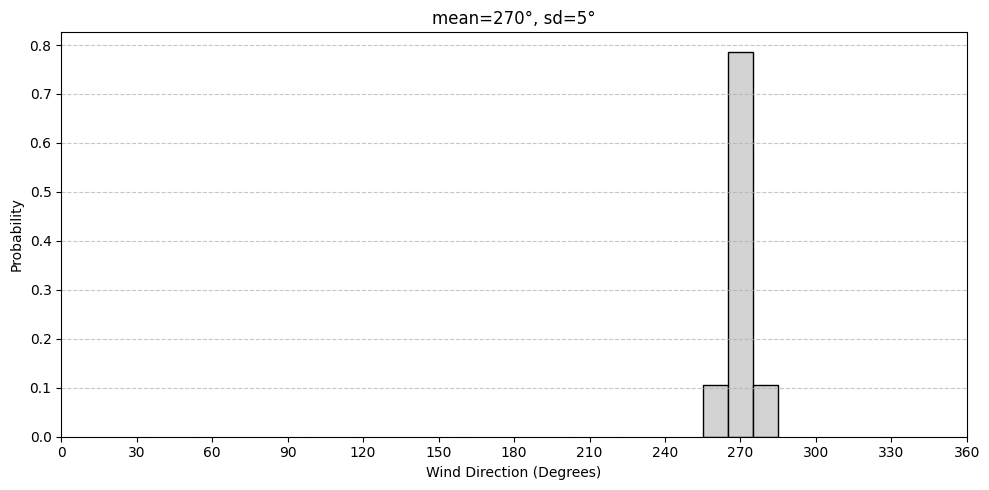

In [62]:
# Generate wind direction distribution
from src.simulate_data import generate_wind_direction_distribution
wind_df = generate_wind_direction_distribution(mu=270, sd=5, wind_speed=8, turbulence_intensity=0.06, step=10)



In [59]:
wind_df

,x_turb2,y_turb2,wind_direction,wind_speed,turbulence_intensity,probability
0,NaN,NaN,250,8,0.06,0.021910
1,NaN,NaN,260,8,0.06,0.228310
2,NaN,NaN,270,8,0.06,0.498675
3,NaN,NaN,280,8,0.06,0.228310
4,NaN,NaN,290,8,0.06,0.021910


# Optimization Model



### Decision Variables
\( x \): x-coordinate of the second turbine relative to the first.
\( y \): y-coordinate of the second turbine relative to the first.

### **Objective Function**
$$ \max_{x, y} P(x, y) $$

### Constraints
$ x_{\min} \leq x \leq x_{\max} $
   
$ y_{\min} \leq y \leq y_{\max} $


In [60]:
from pyomo.environ import ConcreteModel, Var, Objective, Constraint, SolverFactory, minimize, value

### Define the optimization model
model = ConcreteModel()

# set up scenarios with probabilities and contextual information
contextual_sample = wind_df.drop(columns=['probability'])
pi = list(wind_df['probability'])

n_sc = len(contextual_sample)
model.W = pyo.RangeSet(0,n_sc-1)

# set up 
model.var_ind = pyo.Set(initialize=contextual_sample.columns.sort_values())

model.x = pyo.Var(model.var_ind, model.W ,within=pyo.Reals)
model.y = pyo.Var(pyo.Any, dense=False, domain=pyo.Reals) # learned variables (demand)

model.power = pyo.Var(model.W,within=pyo.Reals) # saving power per scenario

model.min_dist = pyo.Param(initialize=100, mutable=False)
model.x_max = pyo.Param(initialize=4000, mutable=False)
model.y_max = pyo.Param(initialize=500, mutable=False)

# obj function 
def obj_expression(model):
    return sum(pi[w-1] * model.power[w] for w in model.W)
model.OBJ = pyo.Objective(rule=obj_expression, sense=pyo.maximize)

#power generation
def power(model, w):
    return model.power[w] == model.y['power', 0, w]
model.const_power = pyo.Constraint(model.W, rule=power)


# Fix contextual variables
def fix_other_vars(model, x_ind, w):
    if x_ind not in ['x_turb2', 'y_turb2']:
        return model.x[x_ind, w] == contextual_sample.loc[w, x_ind]
    return pyo.Constraint.Skip
model.const_fix_other_vars = pyo.Constraint(model.var_ind, model.W, rule=fix_other_vars)

# Constraint to ensure x_turb2 and y_turb2 are the same across all scenarios
def same_across_scenarios(model, var_name):
    first_scenario = next(iter(model.W))
    return (model.x[var_name, first_scenario] == model.x[var_name, w] for w in model.W if w != first_scenario)

model.const_same_x_turb2 = pyo.ConstraintList()
for constraint in same_across_scenarios(model, 'x_turb2'):
    model.const_same_x_turb2.add(constraint)

model.const_same_y_turb2 = pyo.ConstraintList()
for constraint in same_across_scenarios(model, 'y_turb2'):
    model.const_same_y_turb2.add(constraint)


# Upper bounds for x_turb2 and y_turb2
def x_turb2_ub_rule(model, w):
    return model.x['x_turb2', w] <= model.x_max
model.x_turb2_ub = pyo.Constraint(model.W, rule=x_turb2_ub_rule)

def y_turb2_ub_rule(model, w):
    return model.x['y_turb2', w] <= model.y_max
model.y_turb2_ub = pyo.Constraint(model.W, rule=y_turb2_ub_rule)

# Lower bounds for x_turb2 and y_turb2
def x_turb2_ub_rule(model, w):
    return model.x['x_turb2', w] >= 0
model.x_turb2_lb = pyo.Constraint(model.W, rule=x_turb2_ub_rule)

def y_turb2_ub_rule(model, w):
    return model.x['y_turb2', w] >= 0
model.y_turb2_lb = pyo.Constraint(model.W, rule=y_turb2_ub_rule)




# lower bounds for x_turb2 and y_turb2
def distance_constraint(model, w):
    return ((model.x['x_turb2', w] - 0)**2 + (model.x['y_turb2', w] - 0)**2) >= model.min_dist**2
model.distance_constraint = pyo.Constraint(model.W, rule=distance_constraint)

### Constraint Embedding
cl_tool.const_embed_modified(opt_model=model, constaints=cons, outcome='power', deterministic = True, n_scenarios=n_sc)


Secenario  0 embedded
Layer  0 embedded for prediction  0  of outcome  power
Layer  1 embedded for prediction  0  of outcome  power
Layer  2 embedded for prediction  0  of outcome  power
Layer  3 embedded for prediction  0  of outcome  power
Secenario  1 embedded
Layer  0 embedded for prediction  0  of outcome  power
Layer  1 embedded for prediction  0  of outcome  power
Layer  2 embedded for prediction  0  of outcome  power
Layer  3 embedded for prediction  0  of outcome  power
Secenario  2 embedded
Layer  0 embedded for prediction  0  of outcome  power
Layer  1 embedded for prediction  0  of outcome  power
Layer  2 embedded for prediction  0  of outcome  power
Layer  3 embedded for prediction  0  of outcome  power
Secenario  3 embedded
Layer  0 embedded for prediction  0  of outcome  power
Layer  1 embedded for prediction  0  of outcome  power
Layer  2 embedded for prediction  0  of outcome  power
Layer  3 embedded for prediction  0  of outcome  power
Secenario  4 embedded
Layer  0 e

In [61]:
from datetime import datetime

# Solve the optimization problem
solver = SolverFactory('gurobi')
solver.options['threads'] = 8
solver.options['NonConvex'] = 2

logfile_name = f"solver_logs/gurobilog_prob_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log"
results = solver.solve(model, tee=True, logfile=logfile_name)

Read LP format model from file /var/folders/2j/t8d8dcsn1tg5sc8l4kz4_4ch0000gn/T/tmpwg3vxfcz.pyomo.lp
Reading time = 0.05 seconds
x1: 2308 rows, 1540 columns, 56576 nonzeros
Set parameter Threads to value 8
Set parameter NonConvex to value 2
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 24.5.0 24F74)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
Thread count: 6 physical cores, 12 logical processors, using up to 8 threads

Non-default parameters:
NonConvex  2
Threads  8

Optimize a model with 2308 rows, 1540 columns and 56576 nonzeros
Model fingerprint: 0x961195ee
Model has 5 quadratic constraints
Variable types: 790 continuous, 750 integer (750 binary)
Coefficient statistics:
  Matrix range     [3e-07, 1e+03]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [2e-02, 5e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 4e+03]
  QRHS range       [1e+04, 1e+04]
Presolve removed 315 rows and 253 columns
Presolve time: 0.61s
Presolved: 1996 ro

In [ ]:
import re
import glob
import os

obj_values = []
bound_values = []

pattern = re.compile(
    r"(?:H\s*)?\s*\d+\s+\d+.*?(\d+\.\d+)\s+(\d+\.\d+)\s+\d+\.\d+%")

# Find the newest gurobi log file in the solver_logs directory
log_files = glob.glob("solver_logs/gurobilog_prob_20250529_144542.log")

newest_log = max(log_files, key=os.path.getmtime)
with open(newest_log, 'r') as f:
    for line in f:
        match = pattern.search(line)
        if match:
            obj_values.append(float(match.group(1)))
            bound_values.append(float(match.group(2)))





# Plot if any values found
if obj_values and bound_values:
    plt.figure(figsize=(10, 5))
    plt.plot(obj_values, marker='o', label='Objective Value')
    plt.plot(bound_values, marker='x', label='Best Bound')
    plt.xlabel('Iteration')
    plt.ylabel('Value')
    plt.title('Objective and Best Bound Over Iterations (Parsed from Gurobi Log)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No objective or bound values found in the log.")

No objective or bound values found in the log.


In [ ]:
# Plot the objective function value (best found so far) over solver iterations if available

if hasattr(results, 'solver') and hasattr(results.solver, 'iterations'):
    # If the solver provides iteration info (not always available)
    iterations = results.solver.iterations
    obj_history = results.solver.objective_history  # This attribute may not exist for all solvers

    plt.figure(figsize=(8, 4))
    plt.plot(iterations, obj_history, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Objective Function Value')
    plt.title('Objective Function Value Over Iterations')
    plt.grid(True)
    plt.show()
else:
    print("Objective function history over iterations is not available from the solver results.")

Objective function history over iterations is not available from the solver results.


In [ ]:
# print optimization results
print("\nOptimization Results:")

# Print the value of the objective function
print("\nObjective Function Value:")
print(pyo.value(model.OBJ))

# Print x variables (contextual features and decision variables)
print("\nContextual/Decision Variables (x):")
for k in model.x:
    print(f"{k}: {pyo.value(model.x[k])}")




Optimization Results:

Objective Function Value:
3506.885812403817

Contextual/Decision Variables (x):
('turbulence_intensity', 0): 0.06
('turbulence_intensity', 1): 0.06
('turbulence_intensity', 2): 0.06
('wind_direction', 0): 260.0
('wind_direction', 1): 270.0
('wind_direction', 2): 280.0
('wind_speed', 0): 8.0
('wind_speed', 1): 8.0
('wind_speed', 2): 8.0
('x_turb2', 0): 513.8950929203005
('x_turb2', 1): 513.8950929203005
('x_turb2', 2): 513.8950929203005
('y_turb2', 0): 273.85990347972376
('y_turb2', 1): 273.85990347972376
('y_turb2', 2): 273.85990347972376


# Analytics

In [ ]:
data_with_prob = pd.merge(data, wind_df[["wind_direction","probability"]], left_on='wind_direction', right_on='wind_direction', how='left')

In [ ]:
# Calculate the expected total power generation
data_with_prob['prob_weighted_power'] = data_with_prob['farm_power'] * data_with_prob['probability']

# Group by x_turb2 and y_turb2 to sum the expected power for each combination
expected_power_by_location = data_with_prob.groupby(['x_turb2', 'y_turb2'])['prob_weighted_power'].sum().reset_index()

# Drop rows where x_turb2 and y_turb2 are both 0
expected_power_by_location = expected_power_by_location[(expected_power_by_location['x_turb2'] != 0) | (expected_power_by_location['y_turb2'] != 0)]

In [ ]:
# # Visualize the results
# from scipy.interpolate import griddata


# # Colormap with interpolation
# x = expected_power_by_location['x_turb2']
# y = expected_power_by_location['y_turb2']
# z = expected_power_by_location['prob_weighted_power']
# xi, yi = np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100)
# xi, yi = np.meshgrid(xi, yi)
# zi = griddata((x, y), z, (xi, yi), method='linear')

# plt.figure(figsize=(20, 6))
# plt.contourf(xi, yi, zi, levels=100, cmap='viridis')
# cbar = plt.colorbar(label='Expected Power Generated', orientation='horizontal', pad=-0.2, aspect=50, shrink=0.8)
# cbar.ax.set_xlabel('Power (kW)', labelpad=10)

# # Add angles
# for i, angle in enumerate([0, 10, 20, 30, 40, 50, 60, 70, 80, 90]):
#     radians = np.deg2rad(angle)
#     label = f'Degrees °' if i == 0 else None  # Add label only to the first line
#     plt.plot([0, 5000 * np.cos(radians)], [0, 5000 * np.sin(radians)], linestyle='--', color='gray', label=label)


# # Plot minimum distance constraint
# circle = plt.Circle((0, 0), 100, color='black', fill=False, linestyle='-', label='Min Distance Constraint', linewidth=4)
# plt.gca().add_artist(circle)

# # Turbine Positions
# plt.scatter(0, 0, color='red', label='Turbine 1', s=500, edgecolor='black', zorder=10)
# optimal_x = pyo.value(model.x['x_turb2',0])
# optimal_y = pyo.value(model.x['y_turb2',0])
# plt.scatter(optimal_x, optimal_y, color='blue', label='Optimal Turbine 2', s=500, edgecolor='black')

# # Cosmetics
# plt.axis('scaled')
# plt.xlim(x.min(), x.max())
# plt.ylim(y.min(), y.max())
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.9), ncol=3)
# plt.xlabel('x_turb2')
# plt.ylabel('y_turb2')
# #plt.title('Colormap of Turbine 2 Power across x_turb2 and y_turb2 (Interpolated)')
# plt.grid(True)
# plt.show()


In [ ]:
wind_df

,x_turb2,y_turb2,wind_direction,wind_speed,turbulence_intensity,probability
0,NaN,NaN,260,8,0.06,0.106451
1,NaN,NaN,270,8,0.06,0.786571
2,NaN,NaN,280,8,0.06,0.106451


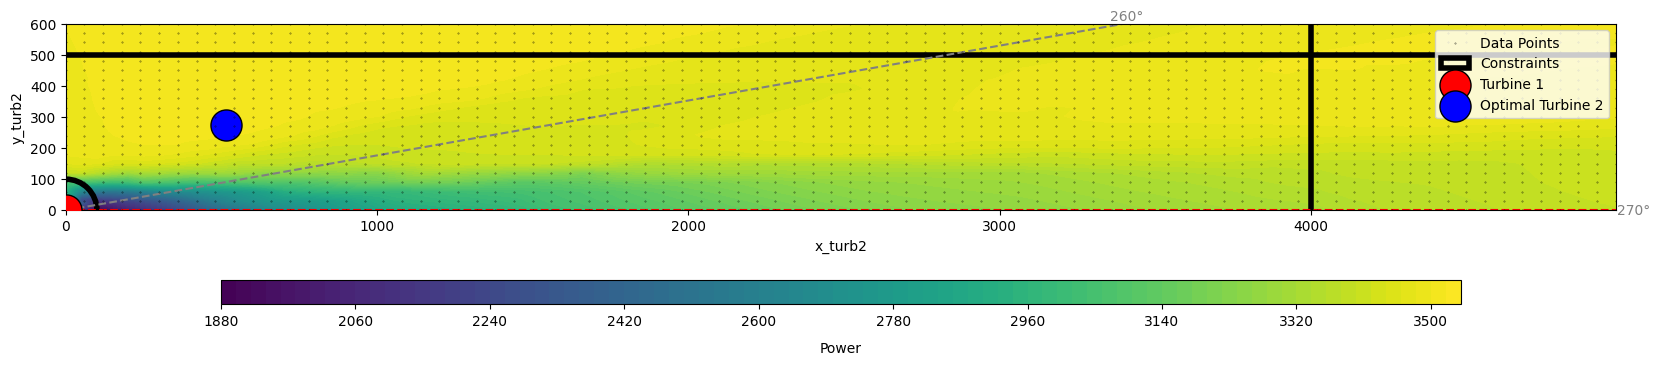

In [ ]:
# Generate Data
x_turb2_range = np.arange(0, 5001, 60)
y_turb2_range = np.arange(0, 601, 30)

results = []
for x_val in x_turb2_range:
    for y_val in y_turb2_range:
        # predict expected power
        exp_power = cl_tool.expected_power_for_location(x_val, y_val, wind_df)
        results.append({'x_turb2': x_val, 'y_turb2': y_val, 'expected_power': exp_power})

expected_power_grid = pd.DataFrame(results)

# plot
plot_two_turbine_results(expected_power_grid, zfeature="expected_power", dpoint_size=0.1,wind_df=wind_df, model_opt=model)


In [ ]:
expected_power = cl_tool.expected_power_for_location(x_turb2_value = pyo.value(model.x['x_turb2', 0]), y_turb2_value = pyo.value(model.x['y_turb2',0]) , wind_df=wind_df)
print(f"Optimal x_turb2: {pyo.value(model.x['x_turb2', 0]):.2f}")
print(f"Optimal y_turb2: {pyo.value(model.x['y_turb2', 0]):.2f}")
print(f"Expected Power (weighted by probability): {expected_power:.2f}")

expected_power_grid.loc[expected_power_grid['expected_power'].idxmax()]



Optimal x_turb2: 513.90
Optimal y_turb2: 273.86
Expected Power (weighted by probability): 3506.75


x_turb2              0.000000
y_turb2              0.000000
expected_power    3539.689209
Name: 0, dtype: float64